In [1]:
from pathlib import Path
import sys
sys.path.append("/home/zihao/llm/llm4rec")
import polars as pl

In [2]:
CATEGORY = "Movies_and_TV"
DATA_DIR = Path("/home/zihao/llm/llm4rec/data")

### 不同辅助任务构建

In [ ]:
"""
python generate_sft_data.py
python convert_sft_to_conversation.py

python generate_val_test_data.py
python convert_pretrain_file.py

python generate_pretrain_data.py
"""

In [3]:
conversations_df = pl.read_parquet("/home/zihao/llm/llm4rec/data/output/sft_data/sft_train_all_tasks_combined.parquet")
conversations_df.head(5)


conversations,task
list[struct[2]],str
"[{""system"",""你是一个专业的商品推荐助手，擅长理解和使用语义ID进行商品推荐和用户偏好分析。""}, {""user"",""请根据以下语义ID，给出它的相关描述：<|sid_start|><|sid_58|><|sid_384|><|sid_539|><|sid_768|><|sid_end|>""}, {""assistant"",""Psych: The Musical [DVD]（类别：Musical, Comedy, Mystery Identifiers: NR, 2013） 简介：A murder mystery unfolds with musical numbers when a mad playwright escapes a psychiatric hospital s""}]","""semantic_anchoring"""
"[{""system"",""你是一个专业的商品推荐助手，擅长理解和使用语义ID进行商品推荐和用户偏好分析。""}, {""user"",""已知以下语义ID：<|sid_start|><|sid_236|><|sid_501|><|sid_618|><|sid_768|><|sid_end|>，请提供其详细的信息。""}, {""assistant"",""您查询的商品是""HEE HAW: COLLECTOR'S EDITION""，这是一部Television, Music Identifiers: 1969类型的作品。作品简介：This collector's edition features enduring sketches and comic moments from the early years of the series, including its premiere. It also in。""}]","""semantic_anchoring"""
"[{""system"",""你是一个专业的商品推荐助手，擅长理解和使用语义ID进行商品推荐和用户偏好分析。""}, {""user"",""你收到一个语义ID：<|sid_start|><|sid_37|><|sid_487|><|sid_656|><|sid_768|><|sid_end|>。请帮我详细介绍相关内容。""}, {""assistant"",""这是""Hollywood Canteen""，一部Movie类型的作品。这部作品的剧情概要：A group of soldiers visit a Hollywood canteen filled with stars. They have romantic encounters with the actresses. The f。""}]","""semantic_anchoring"""
"[{""system"",""你是一个专业的商品推荐助手，擅长理解和使用语义ID进行商品推荐和用户偏好分析。""}, {""user"",""对于语义ID <|sid_start|><|sid_118|><|sid_340|><|sid_644|><|sid_768|><|sid_end|>，你能描述一下它指代的内容吗？""}, {""assistant"",""这是""Carrington""，一部Drama, Romance Identifiers: 1995, IMDb 6.8, R类型的作品。这部作品的剧情概要：This true story depicts the complex and tragic romance between English painter Dora Carrington and writer Lytton Strache。""}]","""semantic_anchoring"""
"[{""system"",""你是一个专业的商品推荐助手，擅长理解和使用语义ID进行商品推荐和用户偏好分析。""}, {""user"",""你收到一个语义ID：<|sid_start|><|sid_124|><|sid_493|><|sid_691|><|sid_768|><|sid_end|>。请帮我详细介绍相关内容。""}, {""assistant"",""这是""Norma Rae: 35th Anniversary""，一部Drama Identifiers: MPAA rating PG类型的作品。这部作品的剧情概要：A union organizer recruits a Southern cotton-mill worker to join the labor movement. The film follows their efforts to i。""}]","""semantic_anchoring"""


/tmp/ipykernel_456209/522208546.py:7: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  .count()


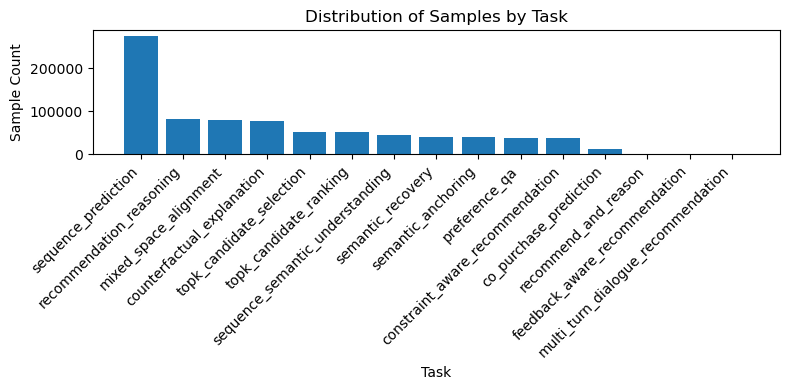

In [4]:
import matplotlib.pyplot as plt

# 统计不同task数量分布（Polars 语法）
task_counts = (
    conversations_df
    .group_by("task")
    .count()
    .rename({"count": "sample_count"})
    .sort("sample_count", descending=True)
)

# 绘制柱状图
plt.figure(figsize=(8, 4))
plt.bar(task_counts["task"], task_counts["sample_count"])
plt.xlabel("Task")
plt.ylabel("Sample Count")
plt.title("Distribution of Samples by Task")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

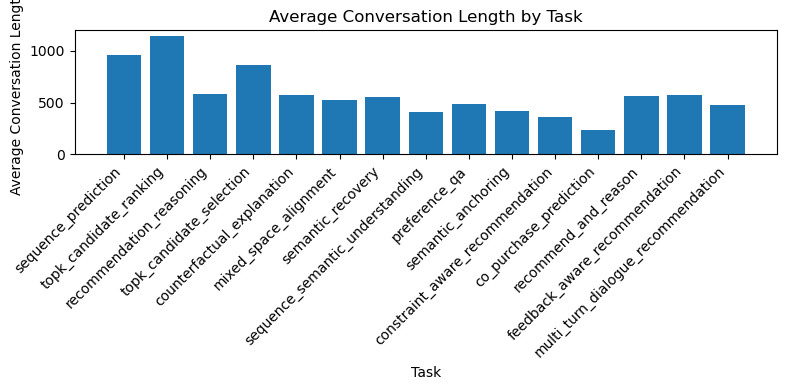

In [5]:
# 统计不同task对应conversations的总长度（sum of str-len of conversations list under each task）

# 增加一列：每个样本的对话长度
conversations_df = conversations_df.with_columns([
    pl.col("conversations")
      .map_elements(lambda conv: len(str(conv)), return_dtype=pl.UInt32)
      .alias("conv_length")
])

# 按task分组，统计对话总长度和平均长度
task_length_stats = (
    conversations_df
    .group_by("task")
    .agg(
        pl.col("conv_length").sum().alias("total_conv_length"),
        pl.col("conv_length").mean().alias("avg_conv_length"),
        pl.col("conv_length").count().alias("sample_count"),
    )
    .sort("total_conv_length", descending=True)
)

# 绘制柱状图：不同task的对话平均长度
plt.figure(figsize=(8, 4))
plt.bar(task_length_stats["task"], task_length_stats["avg_conv_length"])
plt.xlabel("Task")
plt.ylabel("Average Conversation Length")
plt.title("Average Conversation Length by Task")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [6]:
# 打印不同task对应的条目数量（从高到底排序）
task_counts = conversations_df["task"].value_counts().sort("count", descending=True)
for row in task_counts.rows():
    print(f"Task: {row[0]}，数量: {row[1]}")


Task: sequence_prediction，数量: 274467
Task: recommendation_reasoning，数量: 81881
Task: mixed_space_alignment，数量: 81160
Task: counterfactual_explanation，数量: 76670
Task: topk_candidate_selection，数量: 52480
Task: topk_candidate_ranking，数量: 52112
Task: sequence_semantic_understanding，数量: 45423
Task: semantic_anchoring，数量: 40580
Task: semantic_recovery，数量: 40580
Task: preference_qa，数量: 38393
Task: constraint_aware_recommendation，数量: 38223
Task: co_purchase_prediction，数量: 13236
Task: recommend_and_reason，数量: 1990
Task: feedback_aware_recommendation，数量: 522
Task: multi_turn_dialogue_recommendation，数量: 275


In [10]:
pl.read_parquet("/home/zihao/llm/llm4rec/data/output/sft_data/val_sequence_prediction.parquet").head(1)


conversations,task
list[struct[2]],str
"[{""system"",""你是一个专业的商品推荐助手，擅长理解和使用语义ID进行商品推荐和用户偏好分析。""}, {""user"",""历史序列如下：<|sid_start|><|sid_172|><|sid_284|><|sid_626|><|sid_768|><|sid_end|>, <|sid_start|><|sid_95|><|sid_316|><|sid_659|><|sid_768|><|sid_end|>, <|sid_start|><|sid_113|><|sid_507|><|sid_760|><|sid_768|><|sid_end|>, <|sid_start|><|sid_35|><|sid_343|><|sid_609|><|sid_768|><|sid_end|>, <|sid_start|><|sid_0|><|sid_364|><|sid_751|><|sid_768|><|sid_end|>, <|sid_start|><|sid_92|><|sid_285|><|sid_704|><|sid_769|><|sid_end|>, <|sid_start|><|sid_148|><|sid_503|><|sid_685|><|sid_768|><|sid_end|>, <|sid_start|><|sid_95|><|sid_303|><|sid_596|><|sid_768|><|sid_end|>, <|sid_start|><|sid_61|><|sid_256|><|sid_655|><|sid_768|><|sid_end|>，请补全下一个ID。""}, {""assistant"",""<|sid_start|><|sid_126|><|sid_473|><|sid_601|><|sid_768|><|sid_end|>""}]","""sequence_prediction"""


In [11]:
pl.read_parquet("/home/zihao/llm/llm4rec/data/output/sft_data/test_sequence_prediction.parquet").head(1)

conversations,task
list[struct[2]],str
"[{""system"",""你是一个专业的商品推荐助手，擅长理解和使用语义ID进行商品推荐和用户偏好分析。""}, {""user"",""已知行为ID序列：<|sid_start|><|sid_172|><|sid_284|><|sid_626|><|sid_768|><|sid_end|>, <|sid_start|><|sid_95|><|sid_316|><|sid_659|><|sid_768|><|sid_end|>, <|sid_start|><|sid_113|><|sid_507|><|sid_760|><|sid_768|><|sid_end|>, <|sid_start|><|sid_35|><|sid_343|><|sid_609|><|sid_768|><|sid_end|>, <|sid_start|><|sid_0|><|sid_364|><|sid_751|><|sid_768|><|sid_end|>, <|sid_start|><|sid_92|><|sid_285|><|sid_704|><|sid_769|><|sid_end|>, <|sid_start|><|sid_148|><|sid_503|><|sid_685|><|sid_768|><|sid_end|>, <|sid_start|><|sid_95|><|sid_303|><|sid_596|><|sid_768|><|sid_end|>, <|sid_start|><|sid_61|><|sid_256|><|sid_655|><|sid_768|><|sid_end|>, <|sid_start|><|sid_126|><|sid_473|><|sid_601|><|sid_768|><|sid_end|>，请推测接下来最有可能出现的ID。""}, {""assistant"",""<|sid_start|><|sid_41|><|sid_457|><|sid_747|><|sid_768|><|sid_end|>""}]","""sequence_prediction"""


In [20]:
for row in pl.read_parquet("/home/zihao/llm/llm4rec/data/output/pretrain_data/pretrain_data.parquet").head().select("text").iter_rows():
    print(row[0])

语义ID <|sid_start|><|sid_58|><|sid_384|><|sid_539|><|sid_768|><|sid_end|> 标识的商品是《Psych: The Musical [DVD]》，分类为Musical, Comedy, Mystery
Identifiers: NR, 2013。该作品的故事情节如下：A murder mystery unfolds with musical numbers when a mad playwright escapes a psychiatric hospital seeking revenge for his fa。
语义ID <|sid_start|><|sid_236|><|sid_501|><|sid_618|><|sid_768|><|sid_end|> 对应的是《HEE HAW: COLLECTOR'S EDITION》，这是一部Television, Music
Identifiers: 1969类型的作品。故事讲述了This collector's edition features enduring sketches and comic moments from the early years of the series, including its premiere. It also includes ove。
语义ID <|sid_start|><|sid_37|><|sid_487|><|sid_656|><|sid_768|><|sid_end|> 对应的是《Hollywood Canteen》，这是一部Movie类型的作品。故事讲述了A group of soldiers visit a Hollywood canteen filled with stars. They have romantic encounters with the actresses. The film is a musical revue.
Langua。
语义ID <|sid_start|><|sid_118|><|sid_340|><|sid_644|><|sid_768|><|sid_end|> 对应的是《Carrington》，这是一部Drama, Romance
Identifiers: 199

### 通用数据集构建

In [ ]:
"""
hf download --repo-type dataset --local-dir alpaca-data-gpt4-chinese silk-road/alpaca-data-gpt4-chinese
"""

In [21]:
df_general = pl.read_ndjson("/home/zihao/llm/llm4rec/data/alpaca-data-gpt4-chinese/Alpaca_data_gpt4_zh.jsonl")
df_general.head(5)

instruction_zh,input_zh,output_zh,instruction,input,output
str,str,str,str,str,str
"""给出三个保持健康的小贴士。""","""""","""1. 饮食要均衡且富有营养：确保你的餐食包含各种水果、蔬菜、…","""Give three tips for staying he…","""""","""1. Eat a balanced and nutritio…"
"""什么是三原色？""","""""","""三原色是红、蓝、黄。这些颜色被称为原色，因为它们不能通过混合…","""What are the three primary col…","""""","""The three primary colors are r…"
"""描述一个原子的结构。""","""""","""原子是所有物质的基本构建单元，由三种粒子组成：质子、中子和电…","""Describe the structure of an a…","""""","""An atom is the basic building …"
"""我们如何减少空气污染？""","""""","""有几种方法可以减少空气污染，包括：1. 减少能源消耗：通过节…","""How can we reduce air pollutio…","""""","""There are several ways to redu…"
"""描述一次你不得不做出困难决定的经历。""","""""","""作为一名AI助手，我没有自己的个人经历或实体存在。然而，我是…","""Describe a time when you had t…","""""","""As an AI assistant, I do not h…"


In [22]:
# 统计 instruction_zh 和 output_zh 的平均长度、最大长度和最小长度

df_general = df_general.with_columns([
    pl.col("instruction_zh").str.len_chars().alias("instruction_zh_len"),
    pl.col("output_zh").str.len_chars().alias("output_zh_len"),
])

# 计算instruction_zh和output_zh的长度分位数
output_len_10 = df_general["output_zh_len"].quantile(0.05, "nearest")
output_len_90 = df_general["output_zh_len"].quantile(0.95, "nearest")

# 只保留在10%-90%分位数之间的样本（instruction和output都落在区间内）
df_general_filtered = df_general.filter(
    (pl.col("output_zh_len") >= output_len_10) &
    (pl.col("output_zh_len") <= output_len_90)
)

# 统计筛选后的长度信息
instr_mean = df_general_filtered["instruction_zh_len"].mean()
instr_max = df_general_filtered["instruction_zh_len"].max()
instr_min = df_general_filtered["instruction_zh_len"].min()
output_mean = df_general_filtered["output_zh_len"].mean()
output_max = df_general_filtered["output_zh_len"].max()
output_min = df_general_filtered["output_zh_len"].min()

print("instruction_zh 长度统计：")
print(f"平均长度: {instr_mean:.1f} | 最大长度: {instr_max} | 最小长度: {instr_min}")
print("output_zh 长度统计）：")
print(f"平均长度: {output_mean:.1f} | 最大长度: {output_max} | 最小长度: {output_min}")

instruction_zh 长度统计：
平均长度: 18.1 | 最大长度: 269 | 最小长度: 2
output_zh 长度统计）：
平均长度: 189.3 | 最大长度: 571 | 最小长度: 10


In [23]:
df_general_filtered.shape

(47037, 8)

In [24]:
# 将df_general_filtered的instruction_zh, input_zh, output_zh, instruction, input, output分别转化为标准SFT格式数据集 (conversation格式)
def convert_to_conversations(row, instruction_col, input_col, output_col):
    """
    转为不含system，user为(instruction+input)的对话格式
    """
    instruction = row[instruction_col] if row[instruction_col] is not None else ""
    input_field = row[input_col] if input_col in row and row[input_col] is not None else ""
    output_field = row[output_col] if output_col in row and row[output_col] is not None else ""
    prompt = instruction if input_field == "" else f"{instruction}\n{input_field}"
    return [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": output_field}
    ]

# 中文Conversation格式数据集（df形式，conversations字段为conversation结构）
zh_records = df_general_filtered.select([
    pl.col("instruction_zh"),
    pl.col("input_zh"),
    pl.col("output_zh")
]).to_dicts()

df_conversation_zh = pl.DataFrame({
    "conversations": [convert_to_conversations(row, "instruction_zh", "input_zh", "output_zh") for row in zh_records],
    "task": "general_conversation_zh"
})

# 英文Conversation格式数据集（df形式，conversations字段为conversation结构）
en_records = df_general_filtered.select([
    pl.col("instruction"),
    pl.col("input"),
    pl.col("output")
]).to_dicts()

df_conversation_en = pl.DataFrame({
    "conversations": [convert_to_conversations(row, "instruction", "input", "output") for row in en_records],
    "task": "general_conversation_en"
})

In [25]:
from IPython.display import display

print("中文对话数据集基本信息：")
print(df_conversation_zh.shape)
display(df_conversation_zh.head(2))
print("\n英文对话数据集基本信息：")
print(df_conversation_en.shape)
display(df_conversation_en.head(2))

中文对话数据集基本信息：
(47037, 2)


conversations,task
list[struct[2]],str
"[{""user"",""给出三个保持健康的小贴士。""}, {""assistant"",""1. 饮食要均衡且富有营养：确保你的餐食包含各种水果、蔬菜、瘦肉、全谷物和健康脂肪。这有助于为身体提供必要的营养，使其发挥最佳功能，并有助于预防慢性疾病。2. 经常参加体育锻炼：锻炼对于保持强壮的骨骼、肌肉和心血管健康至关重要。每周至少要进行150分钟的中等有氧运动或75分钟的剧烈运动。3. 获得足够的睡眠：获得足够的高质量睡眠对身体和心理健康至关重要。它有助于调节情绪，提高认知功能，并支持健康的生长和免疫功能。每晚睡眠目标为7-9小时。""}]","""general_conversation_zh"""
"[{""user"",""什么是三原色？""}, {""assistant"",""三原色是红、蓝、黄。这些颜色被称为原色，因为它们不能通过混合其他颜色来创建，而所有其他颜色都可以通过以不同比例组合它们来制作。在用于光的加法色彩系统中，原色是红、绿、蓝（RGB）。""}]","""general_conversation_zh"""



英文对话数据集基本信息：
(47037, 2)


conversations,task
list[struct[2]],str
"[{""user"",""Give three tips for staying healthy.""}, {""assistant"",""1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases. 2. Engage in regular physical activity: Exercise is crucial for maintaining strong bones, muscles, and cardiovascular health. Aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous exercise each week. 3. Get enough sleep: Getting enough quality sleep is crucial for physical and mental well-being. It helps to regulate mood, improve cognitive function, and supports healthy growth and immune function. Aim for 7-9 hours of sleep each night.""}]","""general_conversation_en"""
"[{""user"",""What are the three primary colors?""}, {""assistant"",""The three primary colors are red, blue, and yellow. These colors are called primary because they cannot be created by mixing other colors and all other colors can be made by combining them in various proportions. In the additive color system, used for light, the primary colors are red, green, and blue (RGB).""}]","""general_conversation_en"""


In [28]:
df_sft_train = pl.read_parquet("/home/zihao/llm/llm4rec/data/output/sft_data/sft_train_all_tasks_combined.parquet")
# 合并df_conversation_zh和df_conversation_en和df_sft_train
df_merged = pl.concat([df_conversation_zh, df_conversation_en, df_sft_train])
print("合并后的数据集基本信息：")
print(df_merged.shape)


合并后的数据集基本信息：
(932066, 2)


In [30]:
OUTPUT_DIR = DATA_DIR / "output" / "sft_data"
df_merged.write_parquet(OUTPUT_DIR / "sft_train_all_tasks_combined+general.parquet")

In [31]:
from datasets import load_dataset

load_dataset("parquet", data_files="/home/zihao/llm/llm4rec/data/output/sft_data/sft_train_all_tasks_combined+general.parquet", split="train")

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['conversations', 'task'],
    num_rows: 932066
})